In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
import torch
torch.__version__

'1.7.0'

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,random_split
from torchvision.transforms import transforms

In [4]:
def get_train_labels(train_label):
    for i,num in enumerate(train_label):
        if(num> 4.5):
            train_label[i] = 1
        else:
            train_label[i]= 0
            
    return train_label

In [5]:
with open('../input/stftresearch/SFFTFinalData.npy', 'rb') as training_data:
     X= np.load(training_data)

In [6]:
with open('../input/stftresearch/SFFTFinalLabels.npy', 'rb') as training_labels:
     Y= np.load(training_labels)

In [7]:
# cleaning nan
del_rows = []
for i in range(len(X)):
    if(np.isnan(X[i]).sum()>0):
        del_rows.append(i)
        
X = np.delete(X,del_rows,0)
Y = np.delete(Y,del_rows,0)

In [8]:
X.shape

(302987, 70)

In [9]:
Y.shape

(302987, 2)

In [10]:
arousal_labels = np.ravel(Y[:, [0]])
valence_labels = np.ravel(Y[:, [1]])

In [11]:
arousal_labels = get_train_labels(arousal_labels) 
valence_labels = get_train_labels(valence_labels)

In [12]:
class SFTT(nn.Module):

    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv1d(1,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            nn.Conv1d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2,2),

            nn.Conv1d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            nn.AdaptiveAvgPool1d(1),

            nn.Flatten(),
            nn.Linear(256,128),
            nn.Tanh(),
            nn.Linear(128,64),
            nn.Tanh(),
            nn.Linear(64,1),
            nn.Sigmoid()
    )

    def forward(self,xb):
        out = self.network(xb)
        return out
  
    def training_step(self,batch):
        features,label = batch
        out = self(features)
        loss = F.binary_cross_entropy(out,label)
        return loss

    def validation_step(self,batch):
        features,label = batch
        out = self(features)
        loss = F.binary_cross_entropy(out,label)
        acc = accuracy(out,label)
        return {"val_loss": loss.detach(),"val_acc": acc}

    def validation_epoch_end(self,outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(),"val_acc":epoch_acc.item()}

    def epoch_end(self,num_epoch,results):
        print("num_epoch: {}, train_loss: {:.2f}, val_loss: {:.2f}, val_acc: {:.2f}".format(num_epoch+1,results['train_loss'],results['val_loss'], results['val_acc']))

In [13]:
def accuracy(out,label):
    out = (out>0.5)
    pred = (out == label).sum()
    return pred/out.shape[0]

def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(num_epochs,lr,train_loader,val_loader,model,opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(),lr)
    history = []
    for epoch in range(num_epochs):
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        results = evaluate(model,val_loader)
        train_loss = torch.stack(train_losses).mean().item()
        results['train_loss'] = train_loss
        model.epoch_end(epoch,results)
        history.append(results)
    return history

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
def get_plot(history):
    final_train_loss=[]
    final_val_loss=[]
    final_val_acc=[]
    
    for i in history:
        final_train_loss.append(i['train_loss'])
        final_val_loss.append(i['val_loss'])
        final_val_acc.append(i['val_acc'])
        
    epochs=len(history)
    
    fig = plt.figure(figsize=(20,4))
    ax = fig.add_subplot(1, 2, 1)
    plt.title("Epochs vs Loss", fontsize=15)
    plt.plot(list(np.arange(epochs) + 1) , final_train_loss, label='Train')
    plt.plot(list(np.arange(epochs) + 1), final_val_loss, label='Validation')
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.legend(loc='best')
    
    ax = fig.add_subplot(1, 2, 2)
    plt.title("Epochs vs Accuracy")
    plt.plot(list(np.arange(epochs) + 1) ,final_val_acc)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.legend(loc='best')

# Splitting the Dataset and Training

In [15]:
x_a_train,x_a_test,y_a_train,y_a_test=train_test_split(X,np.array(arousal_labels), test_size=0.3,random_state=42)
x_v_train,x_v_test,y_v_train,y_v_test=train_test_split(X,np.array(valence_labels), test_size=0.3,random_state=42)

In [16]:
scaler = StandardScaler()
x_a_train = scaler.fit_transform(x_a_train)
x_a_test = scaler.fit_transform(x_a_test)

x_v_train = scaler.fit_transform(x_v_train)
x_v_test = scaler.fit_transform(x_v_test)

In [17]:
train_a_tensor = torch.tensor(x_a_train,dtype=torch.float32)
train_a_label = torch.tensor(y_a_train,dtype=torch.float32)

test_a_tensor =torch.tensor(x_a_test,dtype=torch.float32)
test_a_label = torch.tensor(y_a_test,dtype=torch.float32)


train_v_tensor = torch.tensor(x_v_train,dtype=torch.float32)
train_v_label = torch.tensor(y_v_train,dtype=torch.float32)

test_v_tensor =torch.tensor(x_v_test,dtype=torch.float32)
test_v_label = torch.tensor(y_v_test,dtype=torch.float32)

In [18]:
train_a_label=train_a_label.unsqueeze(1)
test_a_label=test_a_label.unsqueeze(1)

train_v_label=train_v_label.unsqueeze(1)
test_v_label=test_v_label.unsqueeze(1)

In [19]:
train_a_tensor=train_a_tensor.reshape(train_a_tensor.shape[0],1,70)
test_a_tensor=test_a_tensor.reshape(test_a_tensor.shape[0],1,70)

train_v_tensor=train_v_tensor.reshape(train_v_tensor.shape[0],1,70)
test_v_tensor=test_v_tensor.reshape(test_v_tensor.shape[0],1,70)

In [20]:
print("Train Tensor shape",train_a_tensor.shape)
print("Test Tensor shape",test_a_tensor.shape)

Train Tensor shape torch.Size([212090, 1, 70])
Test Tensor shape torch.Size([90897, 1, 70])


In [21]:
train_arousal = TensorDataset(train_a_tensor, train_a_label)
test_arousal = TensorDataset(test_a_tensor, test_a_label)

train_valence = TensorDataset(train_v_tensor, train_v_label)
test_valence =TensorDataset(test_v_tensor, test_v_label)

In [22]:
val_size = int(0.2 * len(train_arousal))
train_size = len(train_arousal) - val_size

train_a_ds,val_a_ds = random_split(train_arousal,[train_size,val_size])

train_v_ds,val_v_ds = random_split(train_valence,[train_size,val_size])

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
batch_size = 32
train_arousal_loader =  DataLoader(train_a_ds,batch_size=batch_size,shuffle=True)
val_arousal_loader =  DataLoader(val_a_ds,batch_size=batch_size,shuffle=True)
test_arousal_loader =  DataLoader(test_arousal,batch_size=batch_size,shuffle=True)

batch_size = 32
train_valence_loader =  DataLoader(train_v_ds,batch_size=batch_size,shuffle=True)
val_valence_loader =  DataLoader(val_v_ds,batch_size=batch_size,shuffle=True)
test_valence_loader =  DataLoader(test_valence,batch_size=batch_size,shuffle=True)

In [25]:
train_arousal_loader=DeviceDataLoader(train_arousal_loader,device)
val_arousal_loader=DeviceDataLoader(val_arousal_loader,device)
test_arousal_loader=DeviceDataLoader(test_arousal_loader,device)


train_valence_loader = DeviceDataLoader(train_valence_loader,device)
val_valence_loader = DeviceDataLoader(val_valence_loader,device)
test_valence_loader = DeviceDataLoader(test_valence_loader,device)

In [26]:
arousal_model= SFTT()
arousal_model= arousal_model.to(device)

In [27]:
history = fit(10,0.001,train_arousal_loader,val_arousal_loader,arousal_model)

num_epoch: 1, train_loss: 0.34, val_loss: 0.30, val_acc: 0.87
num_epoch: 2, train_loss: 0.23, val_loss: 0.20, val_acc: 0.91
num_epoch: 3, train_loss: 0.20, val_loss: 0.20, val_acc: 0.91
num_epoch: 4, train_loss: 0.17, val_loss: 0.16, val_acc: 0.93
num_epoch: 5, train_loss: 0.15, val_loss: 0.14, val_acc: 0.94
num_epoch: 6, train_loss: 0.13, val_loss: 0.13, val_acc: 0.95
num_epoch: 7, train_loss: 0.12, val_loss: 0.12, val_acc: 0.95
num_epoch: 8, train_loss: 0.11, val_loss: 0.14, val_acc: 0.95
num_epoch: 9, train_loss: 0.10, val_loss: 0.12, val_acc: 0.95
num_epoch: 10, train_loss: 0.09, val_loss: 0.10, val_acc: 0.96


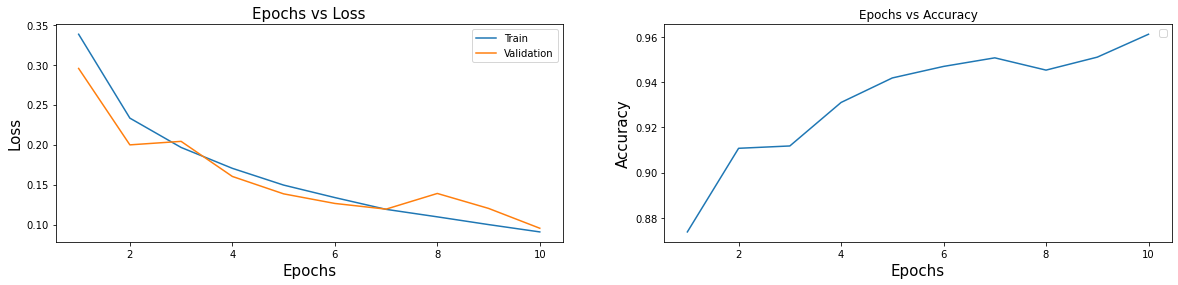

In [28]:
get_plot(history)

In [29]:
evaluate(arousal_model,test_arousal_loader)

{'val_loss': 0.09810669720172882, 'val_acc': 0.9606102705001831}

In [30]:
valence_model= SFTT()
valence_model= valence_model.to(device)

In [31]:
history = fit(10,0.001,train_valence_loader,val_valence_loader,valence_model)

num_epoch: 1, train_loss: 0.43, val_loss: 0.36, val_acc: 0.84
num_epoch: 2, train_loss: 0.31, val_loss: 0.29, val_acc: 0.87
num_epoch: 3, train_loss: 0.27, val_loss: 0.27, val_acc: 0.88
num_epoch: 4, train_loss: 0.24, val_loss: 0.24, val_acc: 0.89
num_epoch: 5, train_loss: 0.21, val_loss: 0.24, val_acc: 0.89
num_epoch: 6, train_loss: 0.19, val_loss: 0.20, val_acc: 0.91
num_epoch: 7, train_loss: 0.17, val_loss: 0.19, val_acc: 0.92
num_epoch: 8, train_loss: 0.16, val_loss: 0.16, val_acc: 0.93
num_epoch: 9, train_loss: 0.15, val_loss: 0.14, val_acc: 0.94
num_epoch: 10, train_loss: 0.13, val_loss: 0.14, val_acc: 0.94


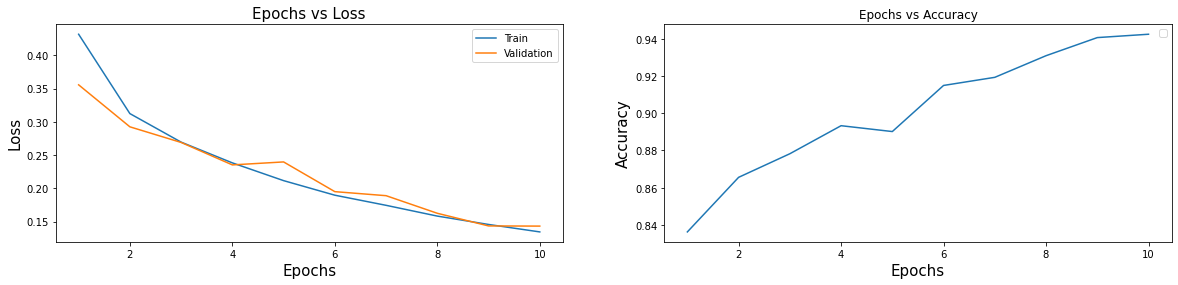

In [32]:
get_plot(history)

In [33]:
evaluate(valence_model,test_valence_loader)

{'val_loss': 0.14668592810630798, 'val_acc': 0.940581202507019}